In [1]:
%load_ext autoreload
%autoreload 3
from data_functions import get_dataset
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler as SRS
from train_utils import SubsetSampler as SS
from sklearn.model_selection import train_test_split as TTS
import torch
import random
import numpy as np
torch.use_deterministic_algorithms(True) # reproducibility

STATE = "SP"
WEEKS = False
TRIANGLE = True
PAST_UNITS = 80
MAX_DELAY = 40
BATCH_SIZE = 64
RANDOM_SPLIT = False
SEED = 1234
DEVICE = "mps"

dataset = get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=PAST_UNITS, max_delay=MAX_DELAY, state=STATE, vector_y = True)
#n_obs_40pu = len(dataset) # 2922 total dates, -39-39 for past_units and max_delay ->2844
## Define train and test indices
if RANDOM_SPLIT:
    all_idcs = range(dataset.__len__())
    train_idcs, test_idcs = TTS(all_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    #train_idcs, test_idcs = [*range(600), *range(950, dataset.__len__())], [*range(600, 950)]
    VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
else:
    if WEEKS: # could also do random split, for now last indices as test
        train_idcs, test_idcs = range(300), range(300, dataset.__len__())
        TEST_BATCH_SIZE = dataset.__len__() - 300
    else: 
        train_idcs, test_idcs = range(int(0.75*dataset.__len__())), range(int(0.75*dataset.__len__()), dataset.__len__()) # 2844 total obs - 711 test, still 25% even without random split, last outbreak 2353
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
        
## Define generator so sampling during training is deterministic and reproducible
g = torch.Generator()
g.manual_seed(SEED)
train_sampler, val_sampler, test_sampler = SRS(train_idcs, generator=g), SRS(val_idcs), SS(test_idcs)
train_loader, val_loader, test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler), DataLoader(dataset, batch_size=VAL_BATCH_SIZE, sampler=val_sampler, shuffle=False), DataLoader(dataset, batch_size=TEST_BATCH_SIZE, sampler=test_sampler, shuffle=False)

## Function to reset the sampler so each training run uses same order of observations for reproducibility
## Possible to define s.t. returns train_loader, but bc in notebook, possible to define globally
def regen_data():
    g = torch.Generator()
    g.manual_seed(SEED)
    global train_loader
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=SRS(train_idcs, generator=g))

def set_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

set_seeds(SEED)


/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:108: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


KeyboardInterrupt: 

In [131]:
import torch.nn as nn
import torch
from NegativeBinomial import NegBin as NB
from torch.distributions import Poisson as Poi
set_seeds(SEED)

## For matrix-like (two-dimensional) input data
class NowcastPNNIndivCounts(nn.Module):
    """ Still NowcastPNN, just this time predicting all individual delay counts as NB distribution.
    This means that there are `lambda` and `phi` for each delay count, and the loss is the log loss for all observations.
    In the end, the values are summed, where the available values (already observed) are fixed and kept in place """
    def __init__(self, past_units = 40, max_delay = 40, hidden_units = [24, 12, 4], conv_channels = [16, 2]):
        super().__init__()
        self.past_units = past_units
        self.max_delay = max_delay
        self.final_dim = past_units# * (2**len(conv_channels))
        self.conv1 = nn.Conv1d(self.max_delay, conv_channels[0], kernel_size=7, padding="same")
        self.conv2 = nn.Conv1d(conv_channels[0], conv_channels[1], kernel_size=7, padding="same")
        #self.conv3 = nn.Conv1d(conv_channels[1], conv_channels[2], kernel_size=7, padding="same")
        #self.conv4 = nn.Conv1d(conv_channels[2], conv_channels[3], kernel_size=7, padding="same")
        self.fc1 = nn.Linear(self.past_units, self.past_units)#, nn.Linear(self.past_units, self.past_units)
        self.fc3, self.fc4 = nn.Linear(self.past_units, hidden_units[0]), nn.Linear(hidden_units[0], hidden_units[1])#, nn.Linear(hidden_units[1], hidden_units[2])
        self.fc5 = nn.Linear(hidden_units[1], hidden_units[2])
        self.fcnb = nn.Linear(hidden_units[-1], 2)
        #self.fcpoi = nn.Linear(hidden_units[-1], 1)
        self.const = 1000 # individual counts not in tens of thousands, but thousands only max, rather hundreds

        self.bnorm1, self.bnorm2 = nn.BatchNorm1d(num_features=self.max_delay), nn.BatchNorm1d(num_features=conv_channels[0])#, nn.BatchNorm1d(num_features=conv_channels[1])#, nn.BatchNorm1d(num_features=conv_channels[2])
        #self.bnorm3 = nn.BatchNorm1d(num_features=conv_channels[1])
        self.bnorm5, self.bnorm6  = nn.BatchNorm1d(num_features=self.max_delay), nn.BatchNorm1d(num_features=self.max_delay)#, nn.BatchNorm1d(num_features=hidden_units[2])
        self.bnorm7 = nn.BatchNorm1d(num_features=self.max_delay)
        self.bnorm_final = nn.BatchNorm1d(num_features=self.max_delay) #hidden_units[1]/self.past_units for single model
        self.attn1 = nn.MultiheadAttention(embed_dim=self.max_delay, num_heads=1, batch_first=True)
        self.drop1, self.drop2, self.drop3 = nn.Dropout(0.3), nn.Dropout(0.2), nn.Dropout(0.1) # optimal 0.15, 0.1 for random split 
        self.softplus = nn.Softplus()
        self.act = nn.SiLU()
    
    def forward(self, x): ## Feed forward function, takes input of shape [batch, past_units, max_delay]
        #x = x.permute(0, 2, 1) # [batch, past_units, max_delay] -> [batch, max_delay, past_units]
        x = x.float()
        ## Attention Block ##
        x_add = x.clone()
        x = self.attn1(x, x, x, need_weights = False)[0]
        x = self.act(self.fc1(x.permute(0,2,1)))
        x = x.permute(0,2,1) + x_add

        """## Convolutional Block ##
        x = x.permute(0, 2, 1) # [batch, past_units, max_delay] -> [batch, max_delay, past_units]
        x = self.act(self.conv1(self.bnorm1(x)))
        x = self.act(self.conv2(self.bnorm2(x))) # [batch, 2, max_delay]
        #x = self.act(self.conv3(self.bnorm3(x)))
        #x = self.act(self.conv4(self.bnorm4(x)))
        #x = x.permute(0, 2, 1) # [batch, max_delay, 2], can think about leaving max delay as last to process"""

        ## Fully Connected Block ##
        #x = x.permute(0, 2, 1) # [batch, past_units, max_delay] -> [batch, max_delay, past_units]
        x = self.drop1(x)
        x = self.act(self.fc3(self.bnorm5(x)))
        x = self.drop2(x)
        x = self.act(self.fc4(self.bnorm6(x)))
        x = self.drop3(x)
        x = self.act(self.fc5(self.bnorm7(x)))
        x = self.fcnb(self.bnorm_final(x))
        ## Need to output lambda nad phi for each batch for whole length
        ## Dim is [batch_size, 2, max_delay] or [batch_size, max_delay, 2]
        dist = NB(lbda = self.const*self.softplus(x[:, :, 0]), phi = (self.const**2)*self.softplus(x[:, :, 1])+1e-5)
        """
        x = self.fcpoi(self.bnorm_final(x))
        dist = Poi(rate=self.const*self.softplus(x)+1e-5)
        """
        return torch.distributions.Independent(dist, reinterpreted_batch_ndims=1)

In [132]:
%reload_ext autoreload
%autoreload 3
from train_utils import train, EarlyStopper
set_seeds(SEED)

regen_data() # reset samplers so each training run is reproducible
early_stopper = EarlyStopper(patience=30, past_units=PAST_UNITS, max_delay=MAX_DELAY, weeks=WEEKS, state="SP", future_obs=0, triangle=TRIANGLE)
nowcast_pnn = NowcastPNNIndivCounts(past_units=PAST_UNITS, max_delay=MAX_DELAY)
#nowcast_pnn = PNNSumDaily(past_units=PAST_UNITS, max_delay=MAX_DELAY)
train(nowcast_pnn, num_epochs=200, train_loader=train_loader, val_loader=val_loader, early_stopper=early_stopper, loss_fct="nll", device = DEVICE)
## Load best set of weights on test/validation set
nowcast_pnn.load_state_dict(torch.load(f"./weights/weights-{PAST_UNITS}-{MAX_DELAY}-{'week' if WEEKS else 'day'}-{('tri' if TRIANGLE else 'sum')}-fut0-{STATE}"))

Epoch 1 - Train loss: 2.79e+04 - Val loss: 2.61e+04 - ES count: 0
Epoch 2 - Train loss: 2.18e+04 - Val loss: 1.98e+04 - ES count: 0
Epoch 3 - Train loss: 1.85e+04 - Val loss: 1.44e+04 - ES count: 0
Epoch 4 - Train loss: 1.63e+04 - Val loss: 1.25e+04 - ES count: 0
Epoch 5 - Train loss: 1.51e+04 - Val loss: 1.18e+04 - ES count: 0
Epoch 6 - Train loss: 1.49e+04 - Val loss: 1.11e+04 - ES count: 0
Epoch 7 - Train loss: 1.43e+04 - Val loss: 9.85e+03 - ES count: 0
Epoch 8 - Train loss: 1.24e+04 - Val loss: 8.86e+03 - ES count: 0
Epoch 9 - Train loss: 1.05e+04 - Val loss: 8.63e+03 - ES count: 0
Epoch 10 - Train loss: 9.38e+03 - Val loss: 8.63e+03 - ES count: 1
Epoch 11 - Train loss: 8.73e+03 - Val loss: 8.48e+03 - ES count: 0
Epoch 12 - Train loss: 8.26e+03 - Val loss: 7.94e+03 - ES count: 0
Epoch 13 - Train loss: 7.86e+03 - Val loss: 7.42e+03 - ES count: 0
Epoch 14 - Train loss: 7.46e+03 - Val loss: 7.04e+03 - ES count: 0
Epoch 15 - Train loss: 7.13e+03 - Val loss: 6.74e+03 - ES count: 0
Epoc

<All keys matched successfully>

In [203]:
from metrics import pnn_PIs_indiv, evaluate_PIs
set_seeds(SEED)
## Write function to generate interval dict, and safe it if desired, then pass to standard evaluate_PI
levels_pnn = pnn_PIs_indiv(nowcast_pnn, test_loader, random_split = RANDOM_SPLIT, save=False, future_obs=0) # can save if good scores and architecture to use for comparisons with others
_ = evaluate_PIs(levels_pnn, test_loader, return_coverages=False, return_is_decomposed=False, total = False)

TypeError: NowcastPNNDOW.forward() missing 1 required positional argument: 'dow'

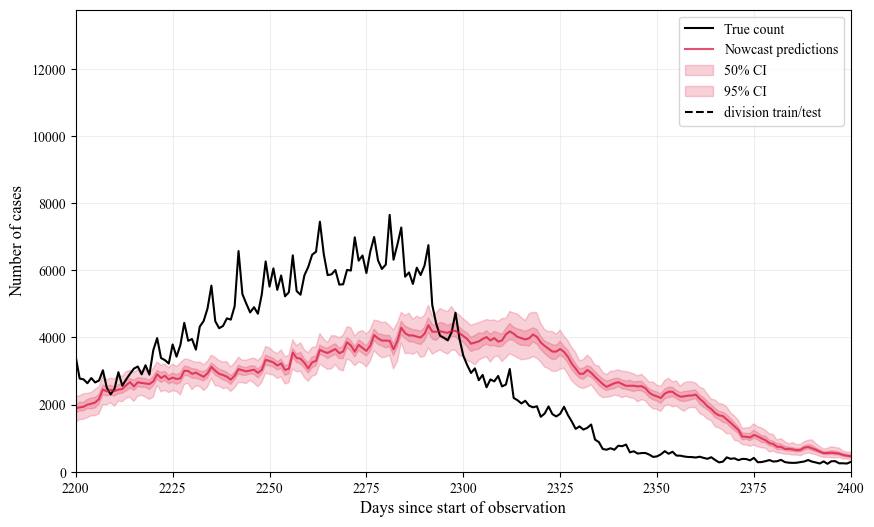

In [135]:
%reload_ext autoreload
%autoreload 3
from plotting import plot_entire_confints
set_seeds(SEED) # biggest outbreak 600, 900
plot_entire_confints(dataset, nowcast_pnn, weeks = WEEKS, random_split = RANDOM_SPLIT, xlims = [2200, 2400], test_idcs=test_idcs, total = False)

# Old structure with day of week as input

In [7]:
%load_ext autoreload
%autoreload 3
from data_functions import get_dataset
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler as SRS
from train_utils import SubsetSampler as SS
from sklearn.model_selection import train_test_split as TTS
import torch, random, os, numpy as np
torch.use_deterministic_algorithms(True) # reproducibility

STATE = "SP"
WEEKS = False
TRIANGLE = True
PAST_UNITS = 80
MAX_DELAY = 40
BATCH_SIZE = 64
RANDOM_SPLIT = False
SEED = 1234
DEVICE = "mps"
DOW = True

dataset_dow = get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=PAST_UNITS, max_delay=MAX_DELAY, state=STATE, dow = DOW)
#n_obs_40pu = len(dataset) # 2922 total dates, -39-39 for past_units and max_delay ->2844
## Define train and test indices
if RANDOM_SPLIT:
    all_idcs = range(dataset_dow.__len__())
    train_idcs, test_idcs = TTS(all_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    #train_idcs, test_idcs = [*range(600), *range(950, dataset.__len__())], [*range(600, 950)]
    VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
else:
    if WEEKS:
        train_idcs, test_idcs = range(300), range(300, dataset_dow.__len__())
        TEST_BATCH_SIZE = dataset.__len__() - 300
    else: 
        train_idcs, test_idcs = range(int(0.75*dataset_dow.__len__())), range(int(0.75*dataset_dow.__len__()), dataset_dow.__len__()) # 2844 total obs - 711 test, still 25% even without random split dataset.__len__(), 2353
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
        
## Define generator so sampling during training is deterministic and reproducible
g = torch.Generator()
g.manual_seed(SEED)
train_sampler_dow, val_sampler_dow, test_sampler_dow = SRS(train_idcs, generator=g), SRS(val_idcs), SS(test_idcs)
train_loader_dow, val_loader_dow, test_loader_dow = DataLoader(dataset_dow, batch_size=BATCH_SIZE, sampler=train_sampler_dow), DataLoader(dataset_dow, batch_size=VAL_BATCH_SIZE, sampler=val_sampler_dow, shuffle=False), DataLoader(dataset_dow, batch_size=TEST_BATCH_SIZE, sampler=test_sampler_dow, shuffle=False)

## Function to reset the sampler so each training run uses same order of observations for reproducibility
## Possible to define s.t. returns train_loader, but bc in notebook, possible to define globally
def regen_data():
    g = torch.Generator()
    g.manual_seed(SEED)
    global train_loader_dow
    train_loader_dow = DataLoader(dataset_dow, batch_size=BATCH_SIZE, sampler=SRS(train_idcs, generator=g))

def regen_loader(seed, dataset, batch_size, idcs):
    g = torch.Generator()
    g.manual_seed(seed)
    gen_loader = DataLoader(dataset, batch_size=batch_size, sampler = SRS(idcs, generator = g))
    return gen_loader

def set_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    random.seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

set_seeds(SEED)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:108: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00


In [8]:
%reload_ext autoreload
%autoreload 3
from train_utils import train, EarlyStopper
from NowcastPNN import NowcastPNNDOW
set_seeds(SEED) # reproducible training runs
regen_data()

early_stopper_dow = EarlyStopper(patience=30, past_units=PAST_UNITS, max_delay=MAX_DELAY, weeks=WEEKS, future_obs=0, random_split=RANDOM_SPLIT, dow = DOW)
nowcast_pnn_dow = NowcastPNNDOW(past_units=PAST_UNITS, max_delay=MAX_DELAY, dropout_probs=[0.3, 0.1] if RANDOM_SPLIT else [0.15, 0.1]) # 0.3, 0.1 best for random split, 0.15, 0.1 for recent
train(nowcast_pnn_dow, num_epochs=200, train_loader=train_loader_dow, val_loader=val_loader_dow, early_stopper=early_stopper_dow, loss_fct="nll", device = "mps", dow = DOW)

## Load best set of weights on test/validation set
nowcast_pnn_dow.load_state_dict(torch.load(f"./weights/weights-{PAST_UNITS}-{MAX_DELAY}-{'week' if WEEKS else 'day'}-fut0{'-rec' if not RANDOM_SPLIT else ''}{'-dow' if DOW else ''}"))

Epoch 1 - Train loss: 2.82e+05 - Val loss: 2.79e+06 - ES count: 0
Epoch 2 - Train loss: 2.69e+05 - Val loss: 2.71e+06 - ES count: 0
Epoch 3 - Train loss: 2.63e+05 - Val loss: 2.25e+06 - ES count: 0
Epoch 4 - Train loss: 2.57e+05 - Val loss: 2.14e+06 - ES count: 0
Epoch 5 - Train loss: 2.53e+05 - Val loss: 2.07e+06 - ES count: 0
Epoch 6 - Train loss: 2.47e+05 - Val loss: 2e+06 - ES count: 0
Epoch 7 - Train loss: 2.42e+05 - Val loss: 1.99e+06 - ES count: 0
Epoch 8 - Train loss: 2.37e+05 - Val loss: 1.92e+06 - ES count: 0
Epoch 9 - Train loss: 2.31e+05 - Val loss: 1.87e+06 - ES count: 0
Epoch 10 - Train loss: 2.25e+05 - Val loss: 1.85e+06 - ES count: 0
Epoch 11 - Train loss: 2.19e+05 - Val loss: 1.74e+06 - ES count: 0
Epoch 12 - Train loss: 2.13e+05 - Val loss: 1.71e+06 - ES count: 0
Epoch 13 - Train loss: 2.07e+05 - Val loss: 1.64e+06 - ES count: 0
Epoch 14 - Train loss: 2e+05 - Val loss: 1.62e+06 - ES count: 0
Epoch 15 - Train loss: 1.93e+05 - Val loss: 1.59e+06 - ES count: 0
Epoch 16 -

<All keys matched successfully>

In [9]:
from metrics import pnn_PIs, evaluate_PIs
set_seeds(SEED)
## Write function to generate interval dict, and safe it if desired, then pass to standard evaluate_PI
levels_pnn_dow = pnn_PIs(nowcast_pnn_dow, test_loader_dow, random_split = RANDOM_SPLIT, save=False, dow = DOW) # can save if good scores and architecture to use for comparisons with others
_ = evaluate_PIs(levels_pnn_dow, test_loader_dow)

Actual coverage per level | 5%: 3.14 | 10%: 5.99 | 25%: 16.55 | 50%: 34.95 | 75%: 55.49 | 90%: 71.75 | 95%: 79.74 |
PICA: 0.11768901569186875
WIS: 440.0225500225241
IS: under = 494.97867588610126 | spread = 343.08008457305885 | over = 485.97178156994954 | total = 1324.0305420291095


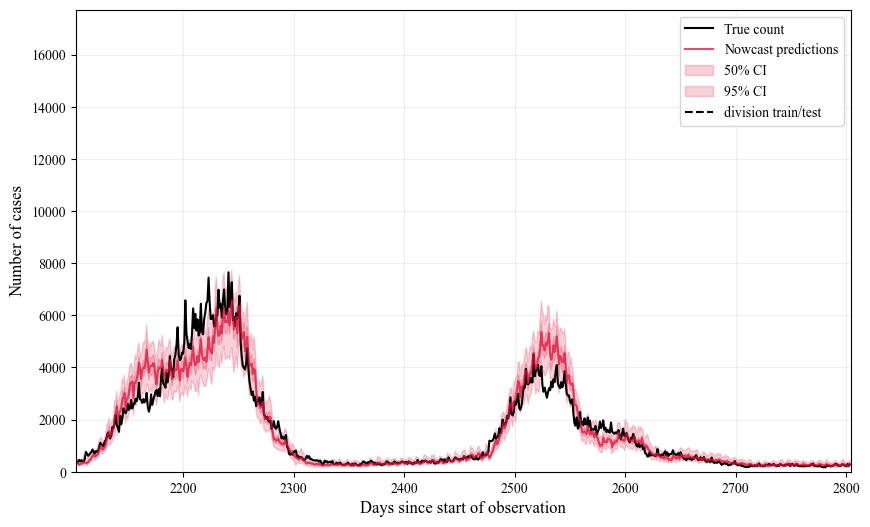

In [10]:
%reload_ext autoreload
%autoreload 3
from plotting import plot_entire_confints
set_seeds(SEED) # biggest outbreak 700, 900, 40 past days recent peak 2133, 2450
plot_entire_confints(dataset_dow, nowcast_pnn_dow, weeks = WEEKS, random_split = RANDOM_SPLIT, xlims = [int(0.75*dataset_dow.__len__()), dataset_dow.__len__()], test_idcs=test_idcs, dow = DOW)

## Biggest outbreak as test set

Use DOW model, same architecture as before

In [75]:
%load_ext autoreload
%autoreload 3
from data_functions import get_dataset
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler as SRS
from train_utils import SubsetSampler as SS
from sklearn.model_selection import train_test_split as TTS
import torch, random, os, numpy as np
torch.use_deterministic_algorithms(True) # reproducibility

STATE = "SP"
WEEKS = False
TRIANGLE = True
PAST_UNITS = 40
MAX_DELAY = 40
BATCH_SIZE = 64
RANDOM_SPLIT = True
BIGGEST_OUTBR = True
SEED = 1234
DEVICE = "mps"
DOW = True

dataset = get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=PAST_UNITS, max_delay=MAX_DELAY, state=STATE, dow = DOW)
if RANDOM_SPLIT:
    all_idcs = range(dataset_dow.__len__())
    train_idcs, test_idcs = [*range(600), *range(950, dataset.__len__())], [*range(600, 950)]
    train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
        
## Define generator so sampling during training is deterministic and reproducible
g = torch.Generator()
g.manual_seed(SEED)
train_sampler, val_sampler, test_sampler = SRS(train_idcs, generator=g), SRS(val_idcs), SS(test_idcs)
train_loader, val_loader, test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler), DataLoader(dataset, batch_size=len(val_idcs), sampler=val_sampler, shuffle=False), DataLoader(dataset, batch_size=len(test_idcs), sampler=test_sampler, shuffle=False)

## Function to reset the sampler so each training run uses same order of observations for reproducibility
## Possible to define s.t. returns train_loader, but bc in notebook, possible to define globally
def regen_data():
    g = torch.Generator()
    g.manual_seed(SEED)
    global train_loader
    train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=SRS(train_idcs, generator=g))

def set_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    random.seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

set_seeds(SEED)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:102: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00


In [80]:
%reload_ext autoreload
%autoreload 3
from train_utils import train, EarlyStopper
from NowcastPNN import NowcastPNNDOW
set_seeds(SEED) # reproducible training runs

#train_loader_dow = regen_loader(SEED, dataset_dow, BATCH_SIZE, train_idcs) # reset samplers so each training run is reproducible
regen_data()

early_stopper = EarlyStopper(patience=30, past_units=PAST_UNITS, max_delay=MAX_DELAY, weeks=WEEKS, future_obs=0, random_split=RANDOM_SPLIT, dow = DOW, biggest_outbreak=BIGGEST_OUTBR)
nowcast_pnn = NowcastPNNDOW(past_units=PAST_UNITS, max_delay=MAX_DELAY, dropout_probs=[0.3, 0.1])
train(nowcast_pnn, num_epochs=200, train_loader=train_loader, val_loader=val_loader, early_stopper=early_stopper, loss_fct="nll", device = "mps", dow = DOW)

## Load best set of weights on test/validation set
nowcast_pnn.load_state_dict(torch.load(f"./weights/weights-{PAST_UNITS}-{MAX_DELAY}-{'week' if WEEKS else 'day'}-fut0-biggest{'-dow' if DOW else ''}"))

KeyboardInterrupt: 

In [78]:
from metrics import pnn_PIs, evaluate_PIs
set_seeds(SEED)
## Write function to generate interval dict, and safe it if desired, then pass to standard evaluate_PI
levels_pnn_bg_out = pnn_PIs(nowcast_pnn, test_loader, random_split = RANDOM_SPLIT, save=True, dow = DOW, biggest_outbreak = BIGGEST_OUTBR) # can save if good scores and architecture to use for comparisons with others
pnn_scores_bg_out = evaluate_PIs(levels_pnn_bg_out, test_loader)

Actual coverage per level | 5%: 5.43 | 10%: 9.71 | 25%: 22.0 | 50%: 42.29 | 75%: 54.57 | 90%: 63.43 | 95%: 69.43 |
PICA: 0.12
WIS: 2093.1694761890826
IS: under = 5226.226191669649 | spread = 508.73590816326526 | over = 23.144079245733383 | total = 5758.106179078647


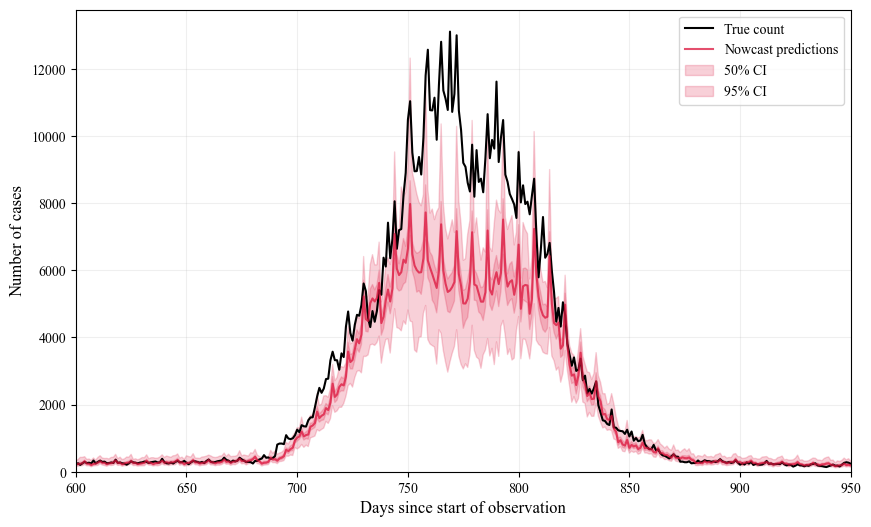

In [79]:
from plotting import plot_entire_confints
set_seeds(SEED) # biggest outbreak 700, 900
plot_entire_confints(dataset, nowcast_pnn, weeks = WEEKS, random_split = RANDOM_SPLIT, xlims = [600, 950], test_idcs=test_idcs, dow = DOW)

In [ ]:
import csv
from plotting import days_to_date

## For use by Epinowcast and RIVM, save as dates directly
start_date = "2013-01-01" 
test_dates = [days_to_date(start_date, days, PAST_UNITS).strftime("%Y-%m-%d") for days in test_idcs]

with open('test_dates_biggest.csv', 'w', newline="") as myfile:
    wr = csv.writer(myfile)
    wr.writerow(test_dates)

In [98]:
packages = """absl-py                           2.1.0
aioftp                            0.21.4
aiohttp                           3.9.3
aiosignal                         1.3.1
anyio                             4.2.0
appnope                           0.1.3
argon2-cffi                       23.1.0
argon2-cffi-bindings              21.2.0
arrow                             1.3.0
asgiref                           3.7.2
asttokens                         2.2.1
astunparse                        1.6.3
async-lru                         2.0.4
attrs                             23.2.0
Babel                             2.14.0
backcall                          0.2.0
bayesian-optimization             1.4.3
beautifulsoup4                    4.12.3
bigtree                           0.12.5
bleach                            6.1.0
certifi                           2023.7.22
cffi                              1.15.1
charset-normalizer                3.3.2
chex                              0.1.86
cloudscraper                      1.2.71
colorama                          0.4.6
comm                              0.1.4
contourpy                         1.1.0
cramjam                           2.8.3
cycler                            0.11.0
datasets                          2.18.0
dateparser                        1.2.0
dbfread                           2.0.7
debugpy                           1.6.7.post1
decorator                         5.1.1
defusedxml                        0.7.1
dill                              0.3.8
Django                            4.2.4
elasticsearch                     7.16.2
epiweeks                          2.3.0
et-xmlfile                        1.1.0
etils                             1.9.2
executing                         1.2.0
fastjsonschema                    2.19.1
fastparquet                       2024.2.0
filelock                          3.13.1
flatbuffers                       24.3.25
flax                              0.8.5
fonttools                         4.42.0
fpdf                              1.7.2
fqdn                              1.5.1
frozenlist                        1.4.1
fsspec                            2023.12.2
gast                              0.5.4
google-pasta                      0.2.0
grpcio                            1.63.0
h11                               0.14.0
h5py                              3.11.0
httpcore                          1.0.2
httpx                             0.26.0
huggingface-hub                   0.21.4
humanize                          4.9.0
idna                              3.6
importlib_resources               6.4.1
ipykernel                         6.25.1
ipython                           8.14.0
ipython-genutils                  0.2.0
ipywidgets                        8.1.1
isoduration                       20.11.0
jax                               0.4.31
jaxlib                            0.4.31
jedi                              0.19.0
Jinja2                            3.1.3
joblib                            1.3.2
json5                             0.9.14
jsonpointer                       2.4
jsonschema                        4.21.1
jsonschema-specifications         2023.12.1
jupyter                           1.0.0
jupyter_client                    8.3.0
jupyter-console                   6.6.3
jupyter_contrib_core              0.4.2
jupyter_contrib_nbextensions      0.7.0
jupyter_core                      5.3.1
jupyter-events                    0.9.0
jupyter-highlight-selected-word   0.2.0
jupyter-lsp                       2.2.2
jupyter-nbextensions-configurator 0.6.3
jupyter_server                    2.12.5
jupyter_server_terminals          0.5.2
jupyterlab                        4.1.0
jupyterlab_pygments               0.3.0
jupyterlab_server                 2.25.2
jupyterlab-widgets                3.0.9
keras                             3.3.3
kiwisolver                        1.4.4
libclang                          18.1.1
loguru                            0.6.0
lxml                              5.1.0
Markdown                          3.6
markdown-it-py                    3.0.0
MarkupSafe                        2.1.4
matplotlib                        3.7.2
matplotlib-inline                 0.1.6
mdurl                             0.1.2
mistune                           3.0.2
ml-dtypes                         0.3.2
mpmath                            1.3.0
msgpack                           1.0.8
multidict                         6.0.5
multiprocess                      0.70.16
namex                             0.0.8
nbclient                          0.9.0
nbconvert                         7.16.0
nbformat                          5.9.2
nest-asyncio                      1.5.7
networkx                          3.2.1
notebook                          7.0.7
notebook_shim                     0.2.3
numpy                             1.26.2
openpyxl                          3.1.2
opt-einsum                        3.3.0
optax                             0.2.3
optree                            0.11.0
orbax-checkpoint                  0.5.23
overrides                         7.7.0
packaging                         23.1
pandas                            2.2.2
pandocfilters                     1.5.1
parso                             0.8.3
patsy                             0.5.3
pexpect                           4.8.0
pickleshare                       0.7.5
Pillow                            10.0.0
pip                               24.2
platformdirs                      3.10.0
prometheus-client                 0.19.0
prompt-toolkit                    3.0.39
protobuf                          4.25.3
psutil                            5.9.5
ptyprocess                        0.7.0
pure-eval                         0.2.2
pyarrow                           15.0.2
pyarrow-hotfix                    0.6
pycparser                         2.21
Pygments                          2.16.1
pyparsing                         3.0.9
pyreaddbc                         1.2.0
pysus                             0.14.0
python-dateutil                   2.8.2
python-json-logger                2.0.7
pytz                              2023.3
PyYAML                            6.0.1
pyzmq                             25.1.1
qtconsole                         5.5.1
QtPy                              2.4.1
referencing                       0.33.0
regex                             2024.5.15
requests                          2.31.0
requests-toolbelt                 1.0.0
rfc3339-validator                 0.1.4
rfc3986-validator                 0.1.1
rich                              13.7.1
rpds-py                           0.17.1
scikit-learn                      1.3.0
scipy                             1.11.1
seaborn                           0.12.2
Send2Trash                        1.8.2
setuptools                        65.5.0
six                               1.16.0
sklearn-pandas                    2.2.0
sniffio                           1.3.0
soupsieve                         2.5
sqlparse                          0.4.4
stack-data                        0.6.2
statsmodels                       0.14.0
sympy                             1.12
tensorboard                       2.16.2
tensorboard-data-server           0.7.2
tensorflow                        2.16.1
tensorflow-io-gcs-filesystem      0.37.0
tensorflow-metal                  1.1.0
tensorstore                       0.1.64
termcolor                         2.4.0
terminado                         0.18.0
threadpoolctl                     3.2.0
tinycss2                          1.2.1
toolz                             0.12.1
torch                             2.4.0
torchaudio                        2.2.0
torchvision                       0.17.0
tornado                           6.3.3
tqdm                              4.64.0
traitlets                         5.9.0
types-python-dateutil             2.8.19.20240106
typing_extensions                 4.9.0
tzdata                            2023.3
tzlocal                           5.2
Unidecode                         1.3.8
uri-template                      1.3.0
urllib3                           1.26.18
urwid                             2.6.12
wcwidth                           0.2.6
webcolors                         1.13
webencodings                      0.5.1
websocket-client                  1.7.0
Werkzeug                          3.0.3
wget                              3.2
wheel                             0.42.0
widgetsnbextension                4.0.9
wrapt                             1.16.0
xgboost                           2.0.1
XlsxWriter                        3.2.0
xxhash                            3.4.1
yarl                              1.9.4
zipp                              3.20.0"""

In [99]:
package_list = ""
for p in packages.split("\n"):
    package_list += "==".join( p.split() )+"\n"

In [100]:
print(package_list)

absl-py==2.1.0
aioftp==0.21.4
aiohttp==3.9.3
aiosignal==1.3.1
anyio==4.2.0
appnope==0.1.3
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asgiref==3.7.2
asttokens==2.2.1
astunparse==1.6.3
async-lru==2.0.4
attrs==23.2.0
Babel==2.14.0
backcall==0.2.0
bayesian-optimization==1.4.3
beautifulsoup4==4.12.3
bigtree==0.12.5
bleach==6.1.0
certifi==2023.7.22
cffi==1.15.1
charset-normalizer==3.3.2
chex==0.1.86
cloudscraper==1.2.71
colorama==0.4.6
comm==0.1.4
contourpy==1.1.0
cramjam==2.8.3
cycler==0.11.0
datasets==2.18.0
dateparser==1.2.0
dbfread==2.0.7
debugpy==1.6.7.post1
decorator==5.1.1
defusedxml==0.7.1
dill==0.3.8
Django==4.2.4
elasticsearch==7.16.2
epiweeks==2.3.0
et-xmlfile==1.1.0
etils==1.9.2
executing==1.2.0
fastjsonschema==2.19.1
fastparquet==2024.2.0
filelock==3.13.1
flatbuffers==24.3.25
flax==0.8.5
fonttools==4.42.0
fpdf==1.7.2
fqdn==1.5.1
frozenlist==1.4.1
fsspec==2023.12.2
gast==0.5.4
google-pasta==0.2.0
grpcio==1.63.0
h11==0.14.0
h5py==3.11.0
httpcore==1.0.2
httpx==0.